In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from tqdm import tqdm  # Optional: for progress tracking
import matplotlib.pyplot as plt
from typing import Dict, Any, Callable, Tuple, Union
from functools import partial
import jax.numpy as jnp

from src.utils.Contact_Matrix import create_contact_matrix, create_contact_matrix_old

In [2]:
def visualize_contact_matrix(matrix, title=None, cmap="Blues", Lx=6):
    """
    Visualize a contact matrix as a heatmap with numerical values displayed.
    
    Args:
        matrix: The contact matrix to visualize (numpy array)
        title: Optional title for the plot
        cmap: Colormap to use (default: "Blues")
        Lx: Size parameter for the figure
        
    Returns:
        fig, ax: The matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(1, 1, figsize=(Lx, Lx))
    im = ax.imshow(matrix, cmap=cmap, vmin=0, vmax=0.6)
    
    # Add colorbar
    #plt.colorbar(im)
    
    # Add title if provided
    if title:
        ax.set_title(title)
    
    # Add row and column labels
    label_list = ["1", "2", "3", "4", "5"]
    ax.set_xticks(np.arange(len(label_list)))
    ax.set_yticks(np.arange(len(label_list)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Add text annotations with the value in each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, f"{matrix[i, j]:.2f}",
                          ha="center", va="center", 
                          color="black" if matrix[i, j] < 0.3 else "white",
                          fontsize=9)
    
    return fig, ax


def my_beta_asymmetric(a: float, b: float, n_groups: int, norm: float = 1.0) -> jnp.ndarray:
    """Generate population sizes based on asymmetric beta distribution with better handling of extreme polarization"""
    # Use the CDF to compute the probability mass in each bin
    from jax.scipy.stats import beta as jbeta
    
    # Create bin edges that divide [0,1] into n_groups equal segments
    bin_edges = jnp.linspace(0, 1, n_groups + 1)
    
    # Calculate probability mass in each bin using the CDF
    bin_probs = jnp.array([jbeta.cdf(bin_edges[i+1], a, b) - jbeta.cdf(bin_edges[i], a, b) for i in range(n_groups)])
    
    # Normalize and scale
    return bin_probs / jnp.sum(bin_probs) * norm

def pol_mean_to_ab(pol: jnp.ndarray, m : jnp.ndarray = 0.5) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Convert variance and mean to alpha, beta parameters of beta distribution
    Args:
        p: polarization values
        m: Mean values
    
    Returns:
        Tuple of (alpha, beta) parameters
    """
    a = -m*(4*(m-1)*m+pol)/pol
    b = 4*m*(m-1)**2/pol +m - 1
    return a, b

def generate_population(N_groups = 5, pol = 1/3, mean = 0.5):
    a, b  = pol_mean_to_ab(pol, mean)
    # Generate population sizes
    group_sizes = my_beta_asymmetric(a, b, N_groups, norm=1.0)
    
    return group_sizes

In [10]:
def calc_tot_contacts_and_homophily(N_groups: int, pol: float, mean: float, homophily: float) -> jnp.ndarray:
    """
    Calculate the total number of contacts for each group based on the given parameters.
    
    Args:
        N_groups: Number of groups
        pol: Polarization parameter
        mean: Mean value for the beta distribution
        N_contacts: Total number of contacts
    
    Returns:
        A numpy array of total contacts for each group
    """
    V = generate_population(N_groups, pol, mean)
    # Calculate the contact matrix based on homophily
    C = create_contact_matrix(N_groups, homophily, V)


    # Create a matrix of squared differences (i-j)^2
    i_indices = jnp.arange(len(V))/len(V)
    j_indices = jnp.arange(len(V))/len(V)
    i_grid, j_grid = jnp.meshgrid(i_indices, j_indices, indexing='ij')
    abs_diffs = 1-2*jnp.abs(i_grid - j_grid) 

    # Vectorized computation
    hom = jnp.sum(jnp.outer(V, V) * C * abs_diffs)
    CM = jnp.sum(jnp.outer(V, V) * C)
    return hom, CM, hom/CM


In [11]:
import numpy as np
NP=50
NH = 50
PP = np.linspace(1/NP/2, 1-1/NP/2, NP)
HH = np.linspace(6/NH/2, 6-6/NH/2, NH)

CONTACTS = np.zeros((NP, NH))
HOMOPHILY = np.zeros((NP, NH))
NORMALIZED_HOMOPHILY = np.zeros((NP, NH))
for i, pol in enumerate(tqdm(PP)):
    for j, homophily in enumerate(HH):
        a,b,c = calc_tot_contacts_and_homophily(5, pol, 0.5, homophily)
        HOMOPHILY[i, j] = a
        CONTACTS[i, j] = b
        NORMALIZED_HOMOPHILY[i, j] = c

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


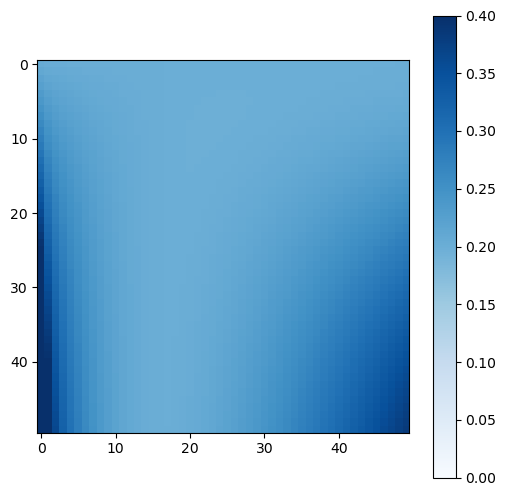

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(CONTACTS.T, cmap="Blues", vmin=0, vmax=0.4)
plt.colorbar(im)

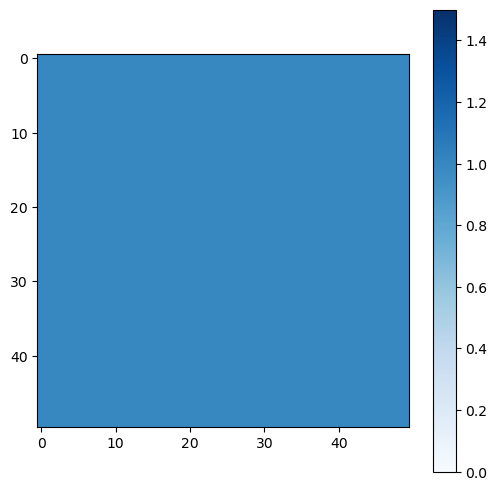

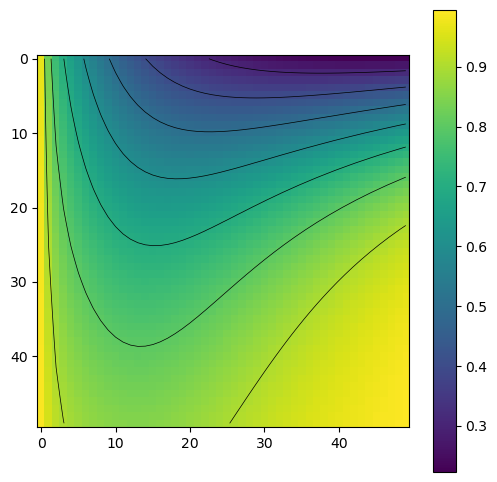

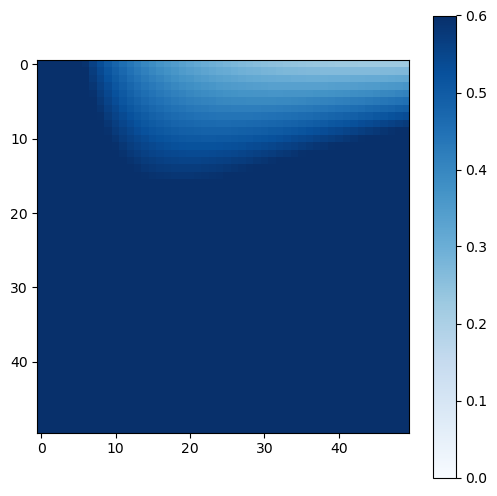

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(CONTACTS.T, cmap="Blues", vmin=0, vmax=1.5)
plt.colorbar(im)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(HOMOPHILY.T)
# contour levels: 0, 1, 2, 3, 4, 5, 6
contour_levels = np.linspace(0,1, 11)
contour = ax.contour(HOMOPHILY.T, levels=contour_levels, colors='black', linewidths=0.5)
plt.colorbar(im)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.imshow(NORMALIZED_HOMOPHILY.T, cmap="Blues", vmin=0, vmax=0.6)
plt.colorbar(im)



2.0 2.0
[0.10400007 0.2480002  0.2959995  0.24800014 0.10400009]


<BarContainer object of 5 artists>

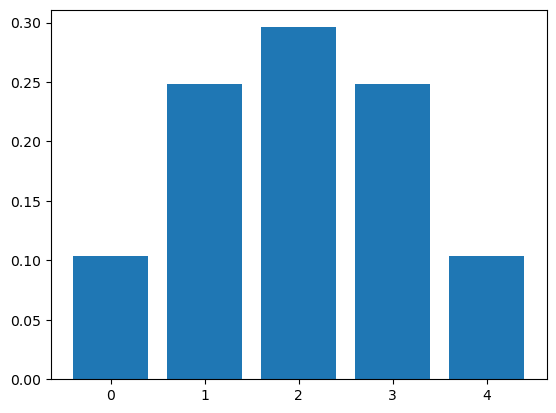

In [34]:
group_sizes = generate_population(N_groups=5, pol=1/5, mean=0.5)
print(group_sizes)

# make a bar plot

plt.bar(range(len(group_sizes)), group_sizes)

(<Figure size 600x600 with 1 Axes>, <Axes: >)

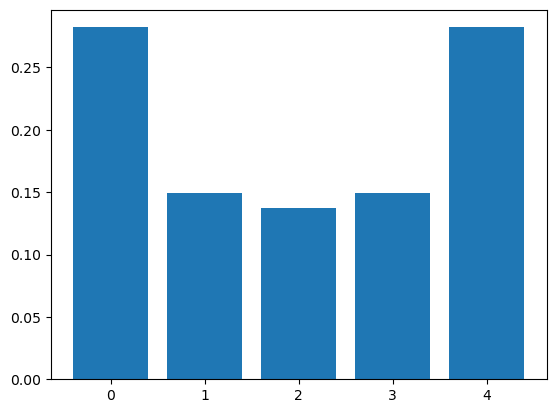

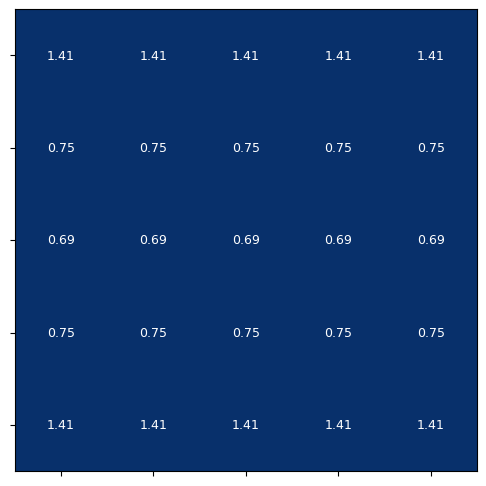

In [ ]:


POP = generate_population(N_groups=5, pol=0.475, mean=0.5)

plt.bar(range(len(POP)), POP)



C = create_contact_matrix(n_groups=5, homophilic_tendency=0, group_sizes=POP)
visualize_contact_matrix(C)

In [89]:
def calc_hom(N, pol, mean, homophilic_tendency):
    POP = generate_population(N_groups=N, pol=pol, mean=mean)
    C = create_contact_matrix(n_groups=N, homophilic_tendency=homophilic_tendency, group_sizes=POP)
    
    homophily = 0
    number_of_contacts = 0
    n_groups = C.shape[0]
    for i in range(n_groups):
        for j in range(n_groups):
            homophily = homophily + C[i,j]*POP[i]*POP[j]*(1-2*np.abs(i/n_groups-j/n_groups))
            number_of_contacts = number_of_contacts + C[i,j]*POP[i]*POP[j]

    return homophily, number_of_contacts

In [113]:
import numpy as np
NA = 20
HOM = np.zeros((NA,2))
NC = np.zeros((NA,2))

hs = np.linspace(-40, 40, NA)
for i, h in enumerate(tqdm(hs)):
    HOM[i,0], NC[i,0] = calc_hom(101, 0.001, 0.5, h)
    #HOM[i,1], NC[i,1] = calc_hom(5, 0.001, 0.5, h)

plt.plot(hs, HOM[:,0]/NC[:,0], label="N=5")
#plt.plot(hs, HOM[:,1]/NC[:,1], label="N=10")

 25%|██▌       | 5/20 [02:23<07:09, 28.66s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
def normalize_by_column(M) -> jnp.ndarray:
    """Normalize each column of the matrix to sum to 1"""
    return M / jnp.sum(M, axis=0, keepdims=True)

def create_contact_matrix(n_groups, homophilic_tendency, group_sizes):
    positions = jnp.linspace(0, 1, n_groups)
    diffs = jnp.abs(positions[:, None] - positions[None, :])
    weights = jnp.exp(-homophilic_tendency * diffs)
    
    C = weights
    # Apply group size weighting
    #for i in range(n_groups):
    #    for j in range(n_groups):
    #        weights = weights[i, j]*group_sizes[i]*group_sizes[j]
    C = weights * jnp.outer(group_sizes, group_sizes)
    # C = weights * group_sizes[:, None]  # Broadcasting group_sizes across columns
    # Normalize to ensure proper contact rates

    C = normalize_by_column(C) * 5
    
    return C